# Notebook for download GO and select 1000 terms for the analysis 

## Step1: Dowload and process GO_BP terms 

In [ ]:
### this function will download go-basic.obo and parse it filtering for biological process branch
# it will output these two files that will be used in the next step:
# collapsed_go.symbol (a network format of GO terms)
# goID_2_name.tab (a mapping of GO terms to their names)

outdir = 'data/GO_BP/'
namespace = 'biological_process'

%run process_the_gene_ontology.py $outdir --namespace $namespace --gobasic $go_basics --goahuman $goahuman

In [4]:
import networkx as nx
import pandas as pd
# function specific to loading the collapsed_go.symbol type file
def load_go(filename): 
    # Create an empty directed graph
    G = nx.DiGraph()

    with open(filename, 'r') as f:
        for line in f:
            columns = line.strip().split('\t')  # tab-separated values
            if len(columns) >= 3:
                parent = columns[0] # based on collapsed_go.symbol, the first column is parent
                child = columns[1] # second column is child
                interaction = columns[2] # third column is interaction type
                # Add an edge to the graph
                G.add_edge(parent, child, interaction=interaction)

    # Get the set of all genes
    hiergeneset = set(n for n in G.nodes() if not n.startswith('GO:'))

    # Get term statistics
    df = get_termStats(G, hiergeneset)

    return df

def get_termStats(G, hiergeneset):
    clusters = list(set(list(G.nodes())) - hiergeneset) #
    tsize_list = []
    cgene_list = []
    for c in clusters:
        infoset = nx.descendants(G, c) # get all the descendants of the cluster
        cgeneset = infoset.intersection(hiergeneset) # get the genes that are in the cluster
        tsize_list.append(len(cgeneset)) 
        cgene_list.append(list(cgeneset))

    df = pd.DataFrame(index=clusters)
    df['Genes'] = [' '.join(genes) for genes in cgene_list] # convert list to string separated by space
    df['Gene_Count'] = tsize_list # number of genes in the cluster
    return df


In [3]:
## use case
## GO version: latest 2023-11-15

go_terms = load_go('./data/GO_BP/collapsed_go.symbol')
go_terms = go_terms.reset_index().rename(columns={'index': 'GO'}) # rename the index column to column name GO
print(go_terms.shape)

# add the go term description
term_des = pd.read_table('./data/GO_BP/goID_2_name.tab',
                                        header=None,
                                        names=['Term', 'Term_Description'],
                                        index_col=0)
go_terms_des = go_terms.merge(term_des, left_on='GO', right_index=True, how='left')

# check if there are any missing values
print(go_terms_des.isnull().sum())

go_terms_des.to_csv('data/go_terms.csv')
go_terms_des.head()

(11943, 3)
GO                  0
Genes               0
Gene_Count          0
Term_Description    0
dtype: int64


,GO,Genes,Gene_Count,Term_Description
0,GO:0006311,TEX11 PRDM9 RNF212,3,meiotic gene conversion
1,GO:0006855,ABCB11 ABCC4 ABCC3 SLC29A2 SLC37A3 SLC19A1 SLC...,16,xenobiotic transmembrane transport
2,GO:0006890,GOLPH3L ARCN1 GBF1 KDELR1 BET1L PICK1 COPZ2 SC...,52,"retrograde vesicle-mediated transport, Golgi t..."
3,GO:1900372,PARP1 FLCN RD3 PID1,4,negative regulation of purine nucleotide biosy...
4,GO:0031645,LPIN1 HCRT GPR35 EIF2AK3 GLRA1 MTNR1B CCN3 MTM...,16,negative regulation of nervous system process


In [5]:
## use case
## GO version: latest 2023-11-15
for branch in ['CC', 'MF']:
    
    go_terms = load_go(f'./data/GO_{branch}/collapsed_go.symbol')
    go_terms = go_terms.reset_index().rename(columns={'index': 'GO'}) # rename the index column to column name GO
    print(go_terms.shape)

    # add the go term description
    term_des = pd.read_table(f'./data/GO_{branch}/goID_2_name.tab',
                                            header=None,
                                            names=['Term', 'Term_Description'],
                                            index_col=0)
    go_terms_des = go_terms.merge(term_des, left_on='GO', right_index=True, how='left')

    # check if there are any missing values
    print(go_terms_des.isnull().sum())

    go_terms_des.to_csv(f'data/GO_term_analysis/CC_MF_branch/{branch}_go_terms.csv')
    

(1677, 3)
GO                  0
Genes               0
Gene_Count          0
Term_Description    0
dtype: int64
(3399, 3)
GO                  0
Genes               0
Gene_Count          0
Term_Description    0
dtype: int64


## Step 2: Understand GO size distribution and select 1000 GO 

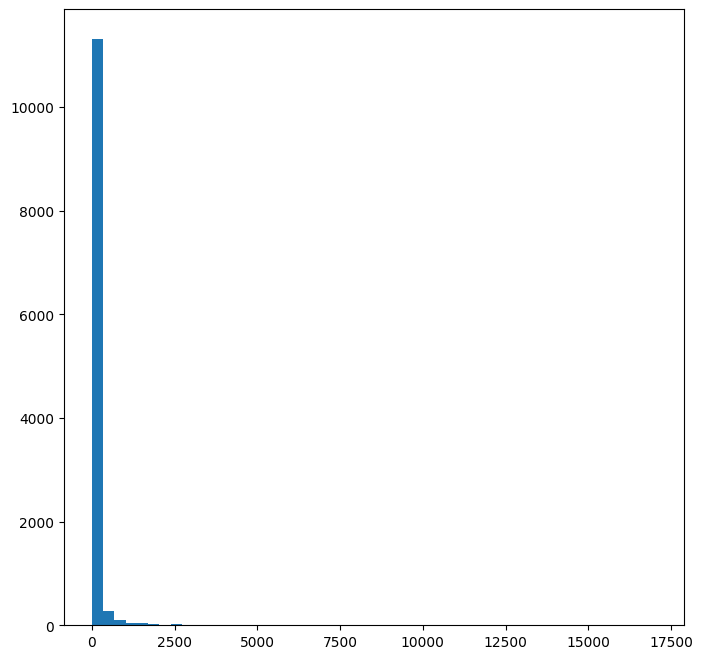

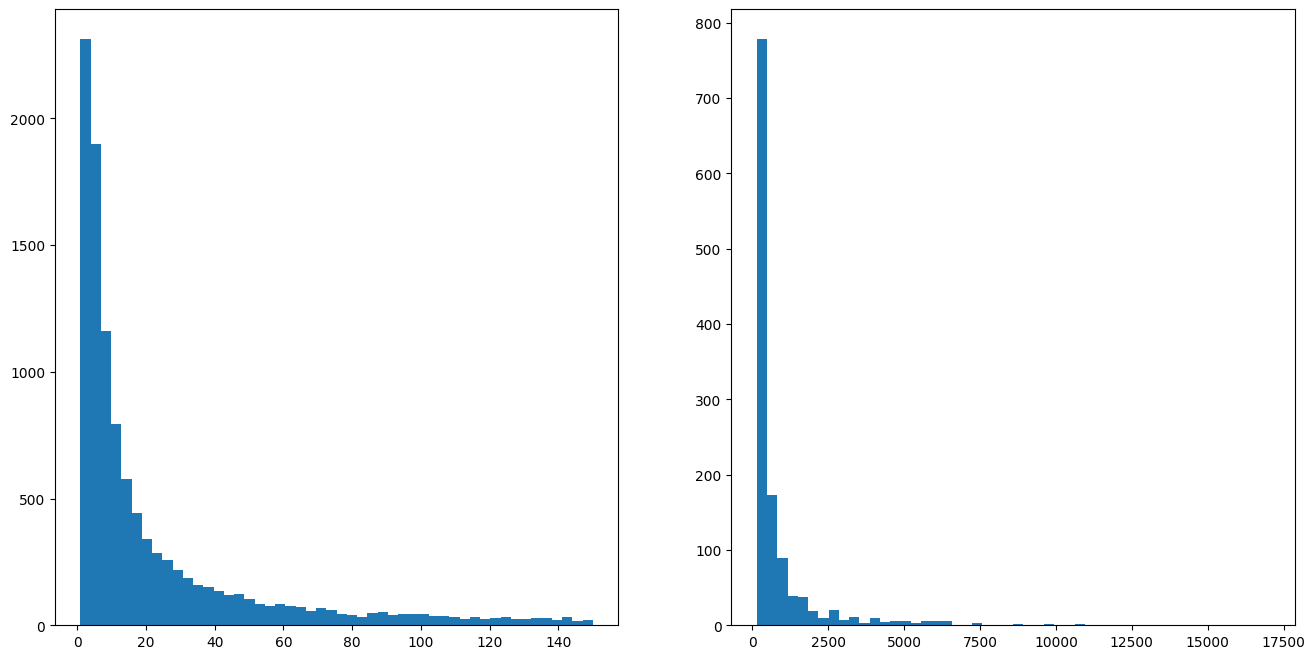

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
go_terms = pd.read_csv('data/go_terms.csv', sep = ',',index_col=0)

plt.figure(figsize=(8,8))
plt.hist(go_terms['Gene_Count'], bins=50)

# subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
ax1.hist(go_terms[(go_terms['Gene_Count'] <= 150)]['Gene_Count'], bins=50)
ax2.hist(go_terms[(go_terms['Gene_Count'] > 150)]['Gene_Count'], bins=50)
plt.show()


In [3]:
# if we randomly select GO terms between 3-100, what percentage of terms will be in the pool?
go_terms[(go_terms['Gene_Count'] >= 3) & (go_terms['Gene_Count'] <= 100)].shape[0]/go_terms.shape[0]



0.746043707611153

        Gene_Count
count  8910.000000
mean     20.143098
std      21.781439
min       3.000000
25%       5.000000
50%      11.000000
75%      26.000000
max     100.000000
(8910, 4)


(array([195., 116., 103.,  64.,  70.,  43.,  35.,  30.,  23.,  27.,  13.,
         22.,  16.,  14.,  14.,  14.,   7.,  14.,  19.,  11.,  14.,   7.,
          8.,   9.,   6.,   5.,   5.,   8.,   5.,   7.,   5.,   3.,   5.,
          3.,   5.,   5.,   7.,   3.,   4.,   3.,   3.,   3.,   4.,   7.,
          4.,   2.,   3.,   2.,   3.,   2.]),
 array([  3.  ,   4.94,   6.88,   8.82,  10.76,  12.7 ,  14.64,  16.58,
         18.52,  20.46,  22.4 ,  24.34,  26.28,  28.22,  30.16,  32.1 ,
         34.04,  35.98,  37.92,  39.86,  41.8 ,  43.74,  45.68,  47.62,
         49.56,  51.5 ,  53.44,  55.38,  57.32,  59.26,  61.2 ,  63.14,
         65.08,  67.02,  68.96,  70.9 ,  72.84,  74.78,  76.72,  78.66,
         80.6 ,  82.54,  84.48,  86.42,  88.36,  90.3 ,  92.24,  94.18,
         96.12,  98.06, 100.  ]),
 <BarContainer object of 50 artists>)

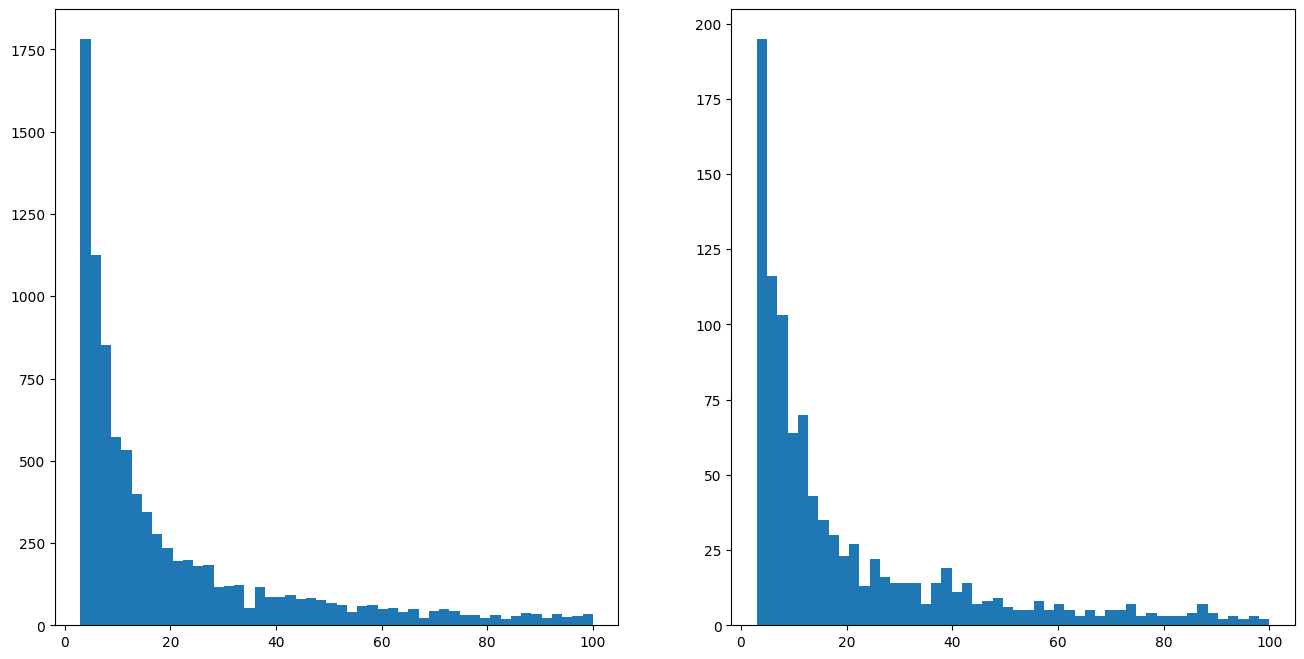

In [2]:
## randomly select 1000 GO terms from the pool between 3-100
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
min = 3
max = 100

go_terms = pd.read_csv('data/go_terms.csv', sep = ',',index_col=0)
go_filtered = go_terms[(go_terms['Gene_Count'] >= min) & (go_terms['Gene_Count'] <= max)]
print(go_filtered.describe())
print(go_filtered.shape)

# randomly select 1000 GO terms from the pool between min and max

selected_go = go_filtered.sample(n=1000, random_state=SEED)

selected_go.to_csv('data/GO_term_analysis/1000_selected_go_terms.csv', index=False)

# quick check of the distribution of the selected GO terms
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
ax1.hist(go_filtered['Gene_Count'], bins=50)
ax2.hist(selected_go['Gene_Count'], bins=50)

In [4]:
print(selected_go.describe())
selected_go.head()

        Gene_Count
count  1000.000000
mean     20.413000
std      21.789613
min       3.000000
25%       6.000000
50%      11.000000
75%      28.000000
max     100.000000


,GO,Genes,Gene_Count,Term_Description
6107,GO:0048627,MEGF10 SDC1 WNT10B SOX15,4,myoblast development
1986,GO:1904888,CPLANE2 NEUROG1 GRHL2 TGFB3 EXT1 TGFBR2 TWIST1...,72,cranial skeletal system development
6624,GO:0019585,DCXR UGT1A9 UGT2B7 PRKCE UGT1A7 UGT2A3 SORD UG...,26,glucuronate metabolic process
10759,GO:1902267,AZIN1 OAZ2 OAZ1 AZIN2 OAZ3,5,regulation of polyamine transmembrane transport
4053,GO:0019748,BDH2 CYP2A7 AKR1C1 ACMSD ATP7A ASIP DDT CYP3A4...,56,secondary metabolic process


        Gene_Count
count  1160.000000
mean     18.095690
std      21.995928
min       3.000000
25%       5.000000
50%       9.000000
75%      20.000000
max     100.000000
CC has 1160 of GO terms between 3 and 100
        Gene_Count
count  2414.000000
mean     15.081607
std      17.861081
min       3.000000
25%       4.000000
50%       8.000000
75%      18.000000
max     100.000000
MF has 2414 of GO terms between 3 and 100


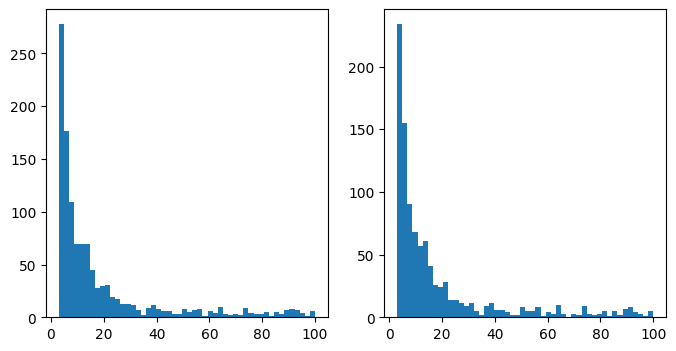

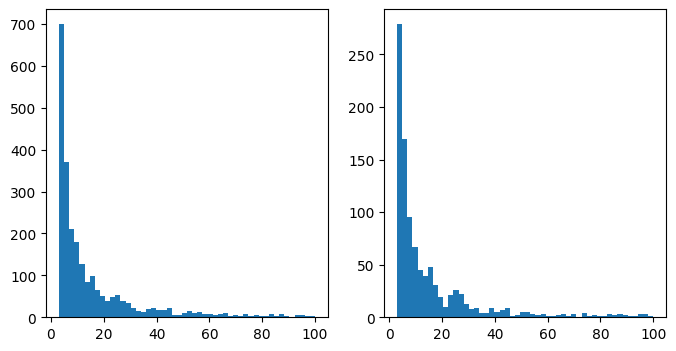

In [10]:
## randomly select 1000 GO terms from the pool between 3-100 for CC and MF
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
min = 3
max = 100
for branch in ['CC', 'MF']:
    go_terms = pd.read_csv(f'data/GO_term_analysis/CC_MF_branch/{branch}_go_terms.csv', sep = ',', index_col=0)
    go_filtered = go_terms[(go_terms['Gene_Count'] >= min) & (go_terms['Gene_Count'] <= max)]
    print(go_filtered.describe())
    print(f'{branch} has {go_filtered.shape[0]} of GO terms between {min} and {max}')

    # randomly select 1000 GO terms from the pool between min and max

    selected_go = go_filtered.sample(n=1000, random_state=SEED)
    assert selected_go.shape[0] == 1000
    selected_go.to_csv(f'data/GO_term_analysis/CC_MF_branch/{branch}_1000_selected_go_terms.csv', index=False)

    # quick check of the distribution of the selected GO terms
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
    ax1.hist(go_filtered['Gene_Count'], bins=50)
    ax2.hist(selected_go['Gene_Count'], bins=50)